In [2]:
%load_ext autoreload
%autoreload 2
    
from yattag import Doc
from yattag import indent

from IPython.core.display import display, HTML
from IPython.display import IFrame

from jinja2 import Template
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from table_parser import TableParser

import matplotlib.pyplot as plt
import os
import cv2

from bs4 import BeautifulSoup
import json
import random
import numpy as np


from table_generation import RandomTableGenerator
from table_style import CSSGenerator, CSSProperty
from html_generator import HTMLTableGenerator, WordGenerator, HTMLTableGeneratorByTemplate, TableStructure

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### CSS generator

In [180]:
with open("css/style_template.css") as f:
    css_template_str = f.read()
    
with open("css/css_properties.json") as f:
    css_default_params = json.load(f)

css_generator = CSSGenerator(css_template_str)

for key, value in css_default_params.items():
    css_generator.add_property(CSSProperty(key, value))

In [181]:
css = css_generator.generate()

In [182]:
print(css.css)

html {
    height:100%;
    width:100%;
    margin:0;
    padding:0;
}

body {
  margin:0;
  padding:0;
  /* background-color: red; */
  /* background-image: url("/Users/meudon/development/sber/table_generation/css/5a68f4a6d2bdc16129fbabcf.jpeg") */
}

table {
  font-family: arial, sans-serif;
  border-collapse: collapse;
  width: 70%;
  height: 70%;
}
    
td {
  /* border:  solid black; */
  text-align: right;
  border-left: solid black 0px;
  border-right: solid black 0px;
  border-top: solid black 0px;
  border-bottom: solid black 0px;
}
    
tr:nth-child(none) {
  background-color: none;
}

th {
  background-color: gray;
  border: 1px solid none;
}


### Word generator

In [18]:
words = []
# with open("words_alpha.txt") as f:
#     for line in f:
#         words.append(line.strip())
with open("data/russian.txt", encoding='cp1251') as f:
    for line in f:
        words.append(line.strip())
word_generator = WordGenerator(words, n_max=6, p=0.5)

### HTML Template generator

In [184]:
with open("html_templates/fin_table.html") as f:
    html_template_str = f.read()
    
html_generator = HTMLTableGeneratorByTemplate(word_generator, html_template_str)
html_table = html_generator.generate()

In [185]:
# html_table.html

### Random Table Generator

In [186]:
random_table_generator = RandomTableGenerator(html_generator, css_generator)
full_table = random_table_generator.generate(name='fin_table')
full_table.save("output/")

### Table parser

In [187]:
chrome_options = Options()
chrome_options.add_argument("disable-extensions")
chrome_options.add_argument("window-position=0,0")
# chrome_options.add_argument("window-size=1000,1000")
chrome_options.add_argument("--hide-scrollbars")

chrome_options.add_argument("headless")

table_parser = TableParser(chrome_options)
parsed_table = table_parser.parse_table("output/fin_table/")

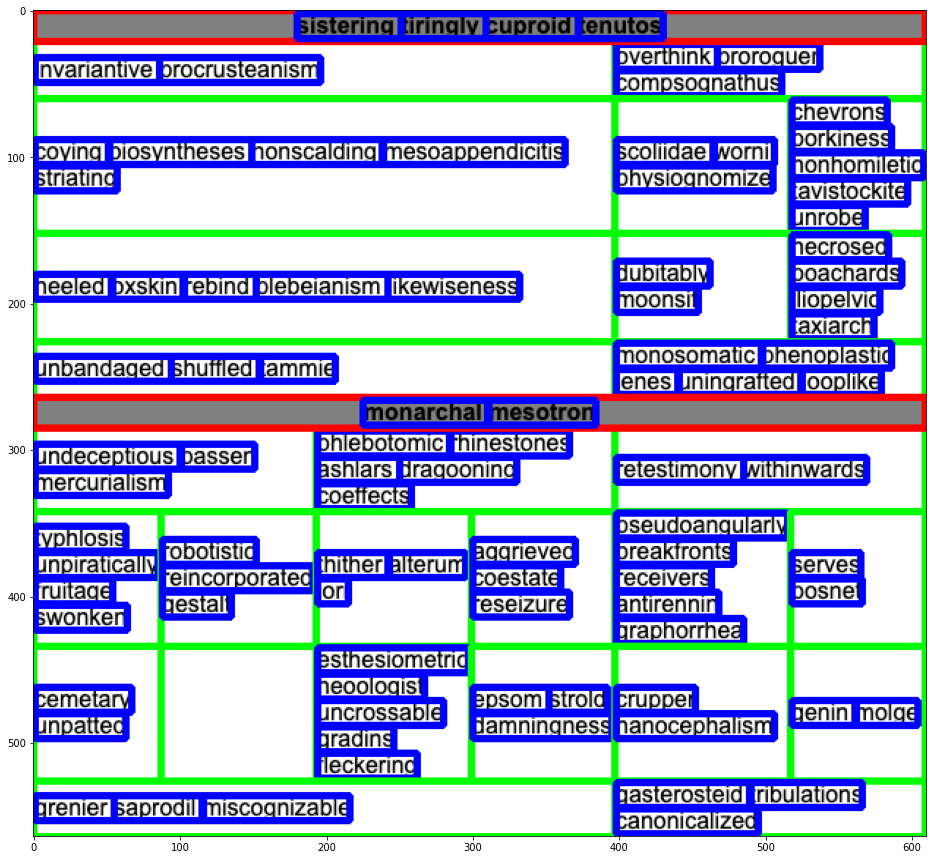

In [188]:
plt.figure(figsize=(16, 16))
plt.imshow(parsed_table.draw_bboxes())

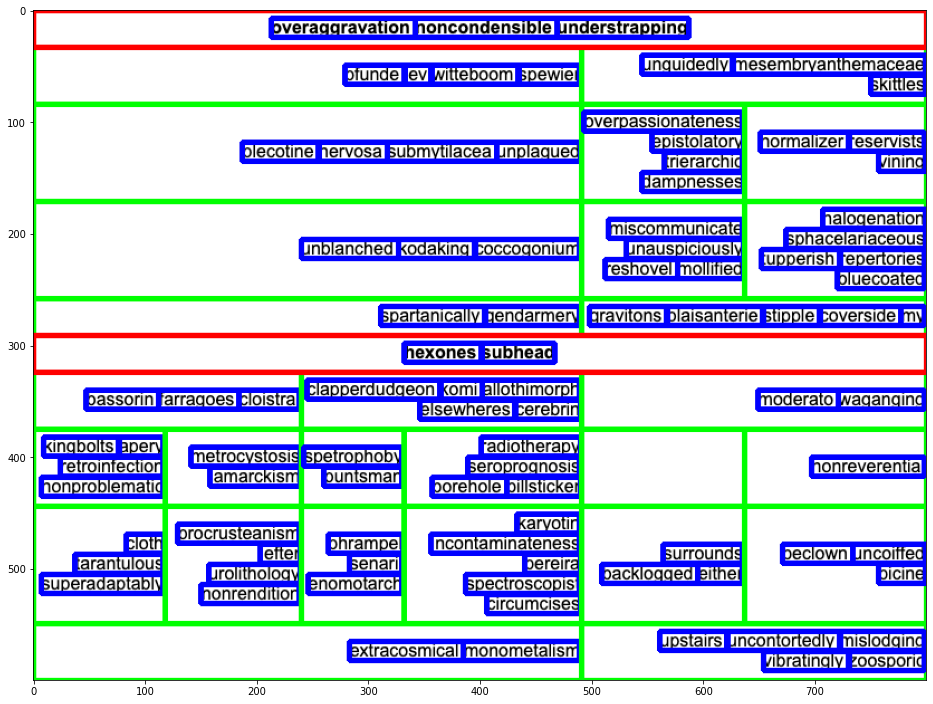

In [179]:
plt.figure(figsize=(16, 16))
plt.imshow(parsed_table.draw_bboxes())

In [12]:
parsed_table.image.dtype

dtype('uint8')

In [13]:
parsed_table.to_annotations()

### HTML table generation

In [121]:
n_rows = 5
n_cols = 5
add_header = False

merge_rows_indx = [-1]
merge_cols_indx = [2, 4]

# table_structure = TableStructure(merge_rows_indx, merge_cols_indx)
# table_structure = TableStructure(merge_rows_indx, None)
table_structure = TableStructure([], merge_cols_indx)
html_generator = HTMLTableGenerator(word_generator, n_rows, n_cols, add_header=add_header, table_structure=table_structure)
html_table = html_generator.generate()

In [122]:
# print(html_table.html)

In [123]:
display(HTML(html_table.html))

In [105]:
random_table_generator = RandomTableGenerator(html_generator, css_generator)
full_table = random_table_generator.generate(name='random_table')
full_table.save("output/")

In [93]:
# parsed_table = table_parser.parse_table("output/random_table/")

In [66]:
# plt.figure(figsize=(16, 16))
# plt.imshow(parsed_table.draw_bboxes())

### Multiple Table generations

In [189]:
with open("css/style_template.css") as f:
    css_template_str = f.read()
    
with open("css/css_properties.json") as f:
    css_default_params = json.load(f)

css_generator = CSSGenerator(css_template_str)

for key, value in css_default_params.items():
    css_generator.add_property(CSSProperty(key, value))
    
with open("html_templates/fin_table.html") as f:
    html_template_str = f.read()

# html_generator = HTMLTableGenerator(word_generator, i, j, add_header=False)
# html_generator = HTMLTableGeneratorByTemplate(word_generator, html_template_str)

# html_table = html_generator.generate()

In [5]:
# With no spans
for i in range(4, 8):
    for j in range(4, 8):
        html_generator = HTMLTableGenerator(word_generator, i, j, add_header=False)
        random_table_generator = RandomTableGenerator(html_generator, css_generator)
        for k in range(50, 100):
            full_table = random_table_generator.generate(name="{0}x{1}_{2}".format(i, j, k))
            full_table.save("output/")

In [201]:
# With spans
N_MIN_ROW = 4
N_MAX_ROW = 8

N_MIN_COL = 4
N_MAX_COL = 8 

TABLE_SIZE_I_J = 50


for i in range(N_MIN_ROW, N_MAX_ROW):
    for j in range(N_MIN_COL, N_MAX_COL):
        if random.randint(0, 1) == 1:
            # cols
            vector_size = random.randint(0, j - 1)
            merge_cols_indx = np.random.choice(j, vector_size, replace=False).tolist()
            
            table_structure = TableStructure([], merge_cols_indx)
        else:
            # rows
            vector_size = random.randint(0, i - 1)
            merge_rows_indx = np.random.choice(i, vector_size, replace=False).tolist()
            
            table_structure = TableStructure(merge_rows_indx, [])
            
        
        html_generator = HTMLTableGenerator(word_generator, n_rows=i, n_cols=j, add_header=False, table_structure=table_structure)
        random_table_generator = RandomTableGenerator(html_generator, css_generator)
        for k in range(0, TABLE_SIZE_I_J):
            full_table = random_table_generator.generate(name="{0}x{1}_{2}_span_{3}".format(i, j, k, vector_size))
            full_table.save("output_with_spans/")

In [202]:
ROOT_DATA = "output_with_spans/"
chrome_options = Options()
chrome_options.add_argument("disable-extensions")
chrome_options.add_argument("window-position=0,0")
chrome_options.add_argument("--hide-scrollbars")

chrome_options.add_argument("headless")

table_parser = TableParser(chrome_options)

parsed_tables = []
for table_path in [file_name for file_name in os.listdir(ROOT_DATA)]:
    if table_path.startswith("."):
        continue
    if "table.png" in os.listdir(ROOT_DATA + table_path):
        continue
    print(table_path)
    parsed_table = table_parser.parse_table(ROOT_DATA + table_path)
    parsed_tables.append(parsed_table)

7x6_36_span_1
6x4_26_span_1
7x4_25_span_0
7x7_5_span_0
7x7_14_span_0
4x5_2_span_2
7x5_14_span_3
7x6_28_span_1
6x4_38_span_1
5x7_12_span_5
7x4_46_span_0
5x5_12_span_1
4x6_33_span_5
6x4_5_span_1
6x5_5_span_1
6x4_45_span_1
7x6_24_span_1
4x5_10_span_2
6x4_34_span_1
7x5_18_span_3
7x4_37_span_0
4x6_42_span_5
6x7_16_span_4
6x4_49_span_1
6x5_9_span_1
6x4_9_span_1
7x7_9_span_0
7x4_29_span_0
4x4_3_span_0
4x6_21_span_5
7x7_18_span_0
7x6_47_span_1
6x7_20_span_4
5x7_28_span_5
7x6_12_span_1
4x5_26_span_2
5x5_28_span_1
7x7_30_span_0
5x7_36_span_5
4x5_38_span_2
7x5_30_span_3
4x5_45_span_2
5x5_36_span_1
6x7_43_span_4
4x6_17_span_5
5x5_47_span_1
7x4_13_span_0
6x7_32_span_4
6x4_10_span_1
4x5_34_span_2
7x5_7_span_3
7x5_41_span_3
4x5_49_span_2
7x7_22_span_0
5x7_47_span_5
5x7_24_span_5
7x7_41_span_0
7x5_22_span_3
5x5_24_span_1
4x4_21_span_0
5x6_41_span_2
5x4_22_span_1
6x6_39_span_1
7x6_9_span_1
4x7_10_span_0
6x6_44_span_1
6x6_27_span_1
5x4_41_span_1
4x4_42_span_0
5x6_22_span_2
6x5_16_span_1
5x6_2_span_2
4x4

In [203]:
for parsed_table in parsed_tables:
    parsed_table.to_annotations()

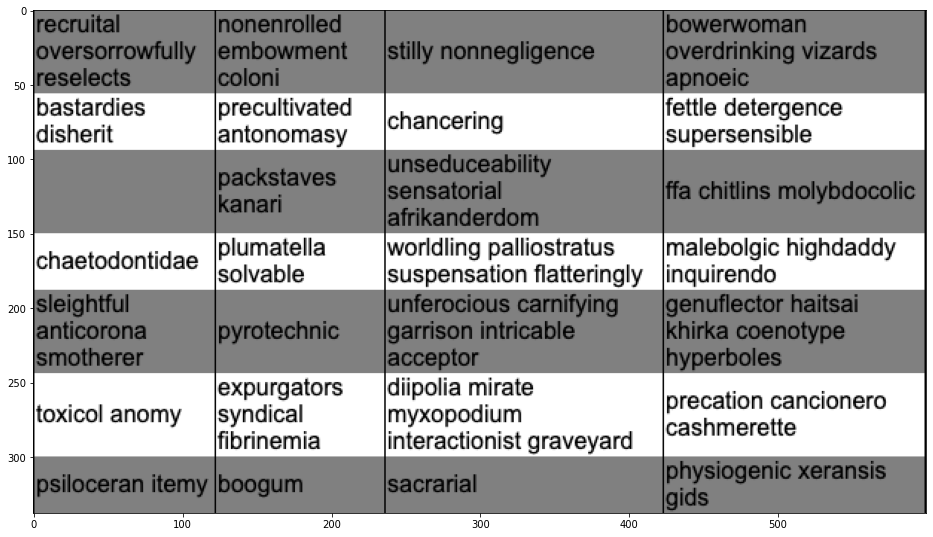

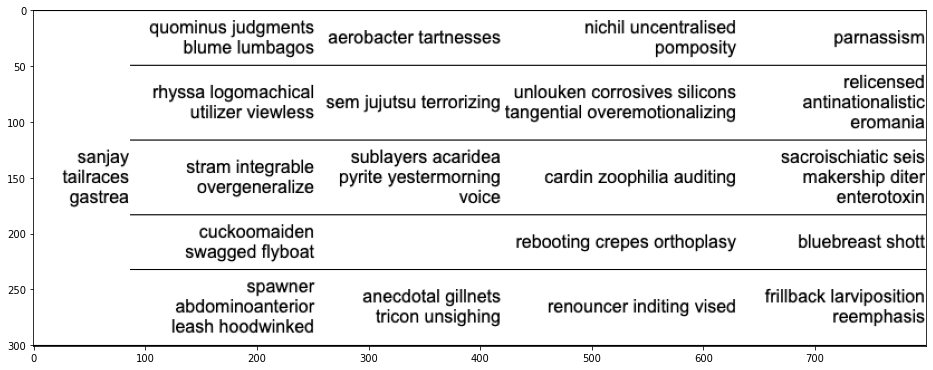

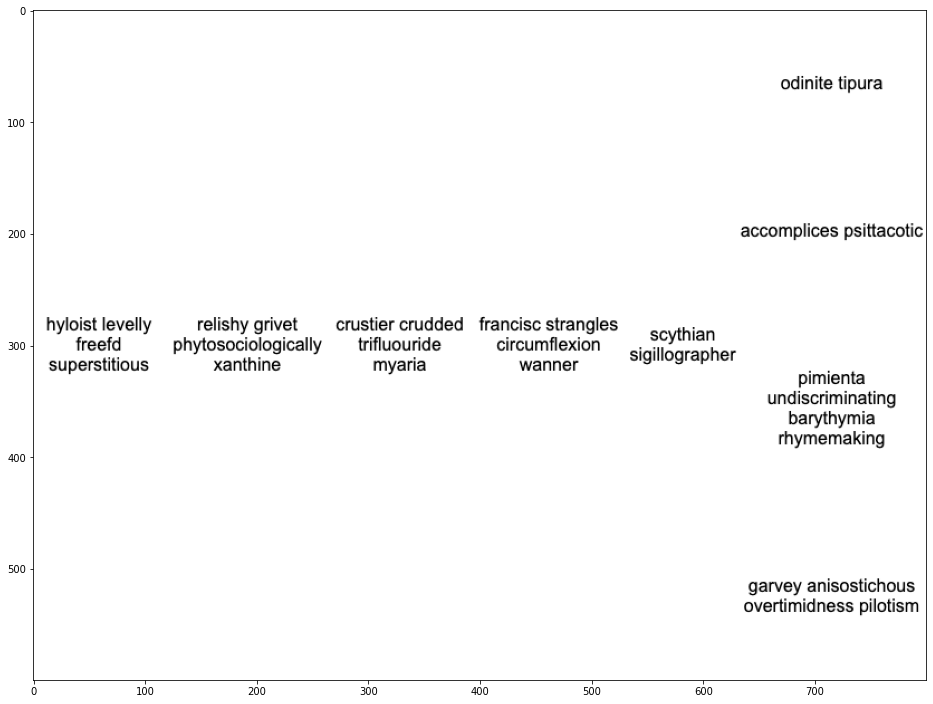

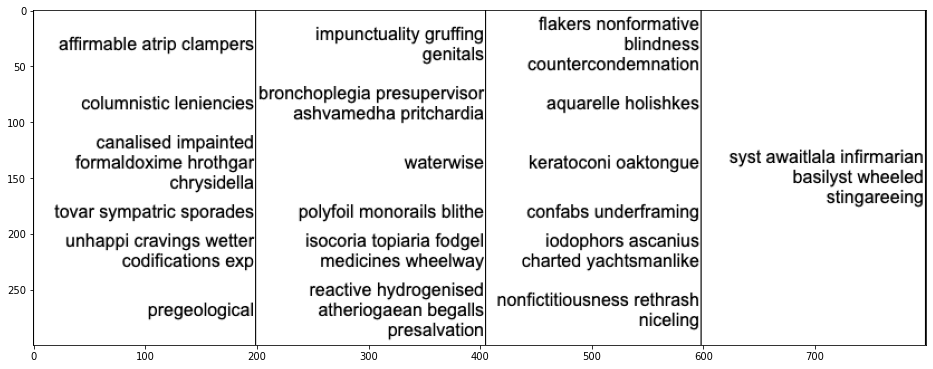

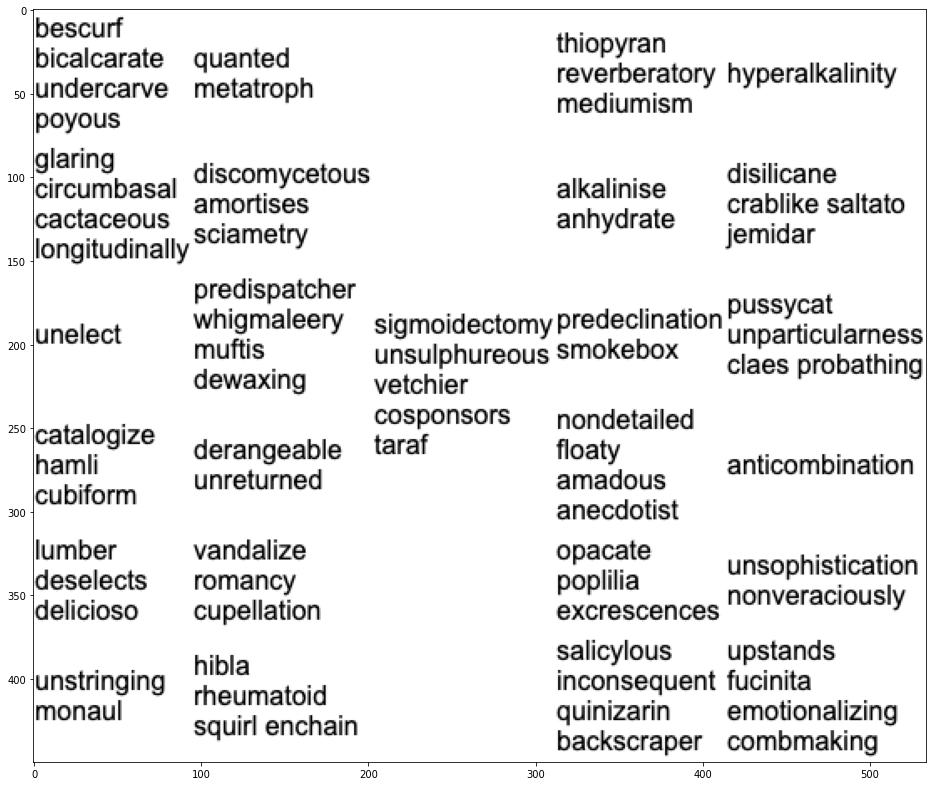

In [206]:
for parsed_table in parsed_tables[10:15]:
    plt.figure(figsize=(16, 16))
    plt.imshow(parsed_table.image)
    plt.show()